<a href="https://colab.research.google.com/github/tashir0605/NLU_Assignment/blob/main/NLU_Q_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original Data Sample:
                                                Text  Label
0  Budget to set scene for election\n \n Gordon B...      0
1  Army chiefs in regiments decision\n \n Militar...      0
2  Howard denies split over ID cards\n \n Michael...      0
3  Observers to monitor UK election\n \n Minister...      0
4  Kilroy names election seat target\n \n Ex-chat...      0
Original Data Shape: (2225, 2)

Filtered Data Shape: (928, 2)
Counts per category:
 Label
1    511
0    417
Name: count, dtype: int64


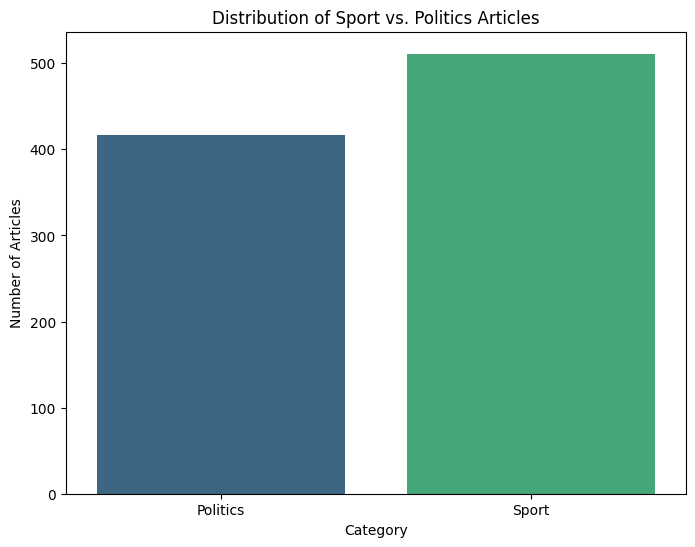

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the dataset
# Replace 'your_dataset.csv' with the actual name of the file you uploaded to Colab
filename = 'df_file.csv'
df = pd.read_csv(filename)

# Display first few rows to verify loading
print("Original Data Sample:")
print(df.head())
print(f"Original Data Shape: {df.shape}")

# 2. Filter the data
# We only want rows where the 'label' is 0 (Politics) or 1 (Sport)
df_binary = df[df['Label'].isin([0, 1])].copy()

# Reset the index so the rows are numbered correctly from 0 to N
df_binary.reset_index(drop=True, inplace=True);

# 3. Check the new data shape
print("\nFiltered Data Shape:", df_binary.shape)
print("Counts per category:\n", df_binary['Label'].value_counts())

# 4. Plot the distribution
plt.figure(figsize=(8, 6))
# Create a temporary column for readable names just for the plot
df_binary['category_name'] = df_binary['Label'].map({0: 'Politics', 1: 'Sport'})

sns.countplot(x='category_name', hue='category_name', data=df_binary, palette='viridis', legend=False)
plt.title('Distribution of Sport vs. Politics Articles')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.show()

In [2]:
df.head()

,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0


In [3]:
df_binary.describe()

,Label
count,928.000000
mean,0.550647
std,0.497697
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [4]:
df_binary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928 entries, 0 to 927
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Text           928 non-null    object
 1   Label          928 non-null    int64 
 2   category_name  928 non-null    object
dtypes: int64(1), object(2)
memory usage: 21.9+ KB


In [5]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
# Initialize Lemmatizer and Stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove URLs and non-letters (keep spaces)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)

    # 3. Tokenize
    tokens = nltk.word_tokenize(text)

    # 4. Remove Stopwords AND Lemmatize (convert "running" -> "run")
    # This reduces feature space and improves generalization
    clean_tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and len(word) > 2 # Remove tiny words
    ]

    return ' '.join(clean_tokens)

# Apply to your dataframe (assuming df_binary exists from previous steps)
print("Preprocessing text...")
df_binary['ProcessedText'] = df_binary['Text'].apply(preprocess_text)

# Check the result
print("Original:", df_binary['Text'].iloc[0][:50])
print("Processed:", df_binary['ProcessedText'].iloc[0][:50])

Preprocessing text...
Original: Budget to set scene for election
 
 Gordon Brown w
Processed: budget set scene election gordon brown seek put ec


In [7]:
# 1. Split Data
X = df_binary['ProcessedText']
y = df_binary['Label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. TF-IDF Vectorization
# min_df=5 means "ignore words that appear in fewer than 5 documents" (removes typos/rare noise)
tfidf = TfidfVectorizer(max_features=3000, min_df=5, ngram_range=(1, 2))

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

print(f"Training Shape: {X_train_tfidf.shape}")
print(f"Validation Shape: {X_val_tfidf.shape}")

Training Shape: (742, 3000)
Validation Shape: (186, 3000)


In [8]:
# 1. Initialize SVM
svm = SVC(kernel='linear', C=1.0, random_state=42)

# 2. Train on the 80% split
svm.fit(X_train_tfidf, y_train)

# 3. Predict on Validation set
y_pred = svm.predict(X_val_tfidf)

# 4. Evaluation
print("--- Single Split Results ---")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(classification_report(y_val, y_pred))

# 5. Cross-Validation (The "Truth" Test)
print("\n--- Cross-Validation Results (5-Folds) ---")
# We use the full X and y here to test robustness across the whole dataset
X_full_tfidf = tfidf.fit_transform(X) # Re-fit on full data for CV
cv_scores = cross_val_score(svm, X_full_tfidf, y, cv=5)

print(f"CV Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")

--- Single Split Results ---
Accuracy: 0.9946
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        79
           1       0.99      1.00      1.00       107

    accuracy                           0.99       186
   macro avg       1.00      0.99      0.99       186
weighted avg       0.99      0.99      0.99       186


--- Cross-Validation Results (5-Folds) ---
CV Scores: [0.98924731 1.         0.98924731 1.         1.        ]
Mean Accuracy: 0.9957


In [9]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import pandas as pd

# 1. Define the other two models
# We already have SVM results, now we need these two:
models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression()
}

results = []

# 2. Train and Evaluate each
print("--- Training Comparison Models ---")
for name, model in models.items():
    # Train
    model.fit(X_train_tfidf, y_train)

    # Predict
    y_pred_new = model.predict(X_val_tfidf)

    # Calculate Accuracy
    acc = accuracy_score(y_val, y_pred_new)

    # Store result
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Accuracy %": f"{acc*100:.2f}%"
    })

    print(f"\n{name} Report:")
    print(classification_report(y_val, y_pred_new))

# 3. Add your SVM result manually (from your previous run)
results.append({
    "Model": "Support Vector Machine (SVM)",
    "Accuracy": 0.9946, # From your single split result
    "Accuracy %": "99.46%"
})

# 4. Create Final Comparison Table
comparison_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

print("\n\n==========================================")
print("       FINAL MODEL COMPARISON TABLE       ")
print("==========================================")
print(comparison_df)

--- Training Comparison Models ---

Multinomial Naive Bayes Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00       107

    accuracy                           1.00       186
   macro avg       1.00      1.00      1.00       186
weighted avg       1.00      1.00      1.00       186


Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        79
           1       0.98      1.00      0.99       107

    accuracy                           0.99       186
   macro avg       0.99      0.99      0.99       186
weighted avg       0.99      0.99      0.99       186



       FINAL MODEL COMPARISON TABLE       
                          Model  Accuracy Accuracy %
0       Multinomial Naive Bayes  1.000000    100.00%
2  Support Vector Machine (SVM)  0.994600     99.46%
1           Logistic Regression  0.989247    

In [10]:
# Get the feature names (words)
feature_names = tfidf.get_feature_names_out()

# Get the probability coefficients from Naive Bayes
# (prob of word given class)
sport_prob_sorted = models['Multinomial Naive Bayes'].feature_log_prob_[1, :].argsort()[::-1]
politics_prob_sorted = models['Multinomial Naive Bayes'].feature_log_prob_[0, :].argsort()[::-1]

print("--- Top 20 Keywords for SPORT ---")
print(np.take(feature_names, sport_prob_sorted[:20]))

print("\n--- Top 20 Keywords for POLITICS ---")
print(np.take(feature_names, politics_prob_sorted[:20]))

--- Top 20 Keywords for SPORT ---
['germany' 'said many' 'police said' 'wilson' 'entirely' 'coach' 'matthew'
 'worker' 'five' 'champion league' 'police' 'teammate' 'cut' 'year'
 'launched' 'simple' 'secretary jack' 'secret' 'coach andy' 'january']

--- Top 20 Keywords for POLITICS ---
['said many' 'landed' 'past' 'employment' 'blair told' 'worst' 'gregory'
 'tory say' 'minute second' 'brown would' 'personal' 'tax cut' 'loss'
 'pledged' 'science' 'ian' 'professional' 'professor' 'qualified'
 'chancellor gordon']


In [11]:
# Create some brand new, unseen sentences
new_test_data = [
    "The prime minister announced a new tax cut for the middle class today.", # Politics
    "The goalkeeper made a fantastic save in the final minute of the match.", # Sport
    "The government is discussing the new budget proposal in parliament.",    # Politics
    "The team captain was injured during the training session."               # Sport
]

# Transform them using the SAME vectorizer (do not fit_transform, just transform)
new_test_tfidf = tfidf.transform(new_test_data)

# Predict
predictions = models['Multinomial Naive Bayes'].predict(new_test_tfidf)

print("--- Real World Test ---")
for text, pred in zip(new_test_data, predictions):
    label = "Sport" if pred == 1 else "Politics"
    print(f"Text: {text[:40]}...  ->  Prediction: {label}")

--- Real World Test ---
Text: The prime minister announced a new tax c...  ->  Prediction: Politics
Text: The goalkeeper made a fantastic save in ...  ->  Prediction: Sport
Text: The government is discussing the new bud...  ->  Prediction: Politics
Text: The team captain was injured during the ...  ->  Prediction: Politics


/tmp/ipython-input-3233453430.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Model", y="Score", data=plot_data, palette="viridis")


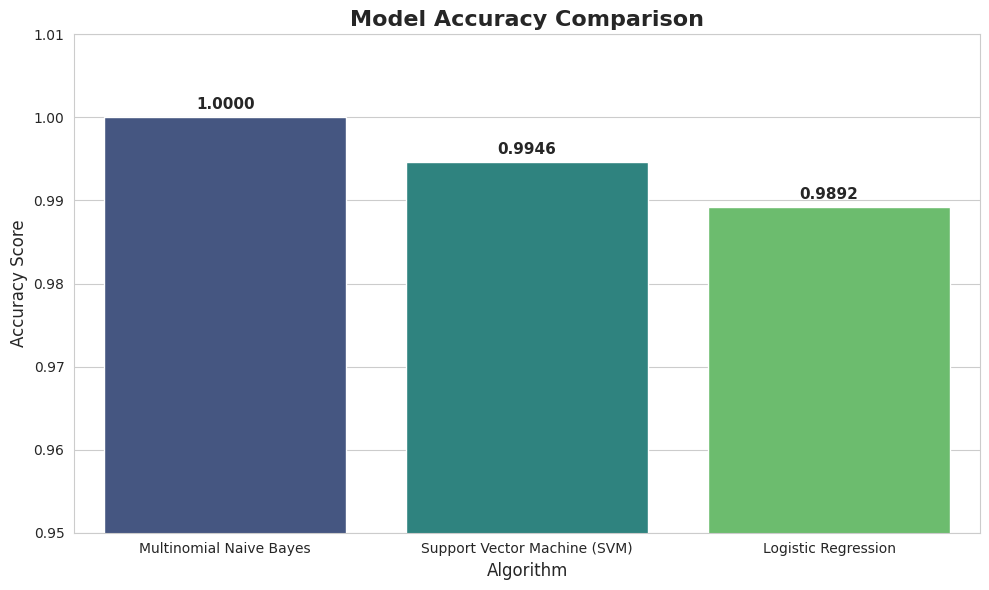

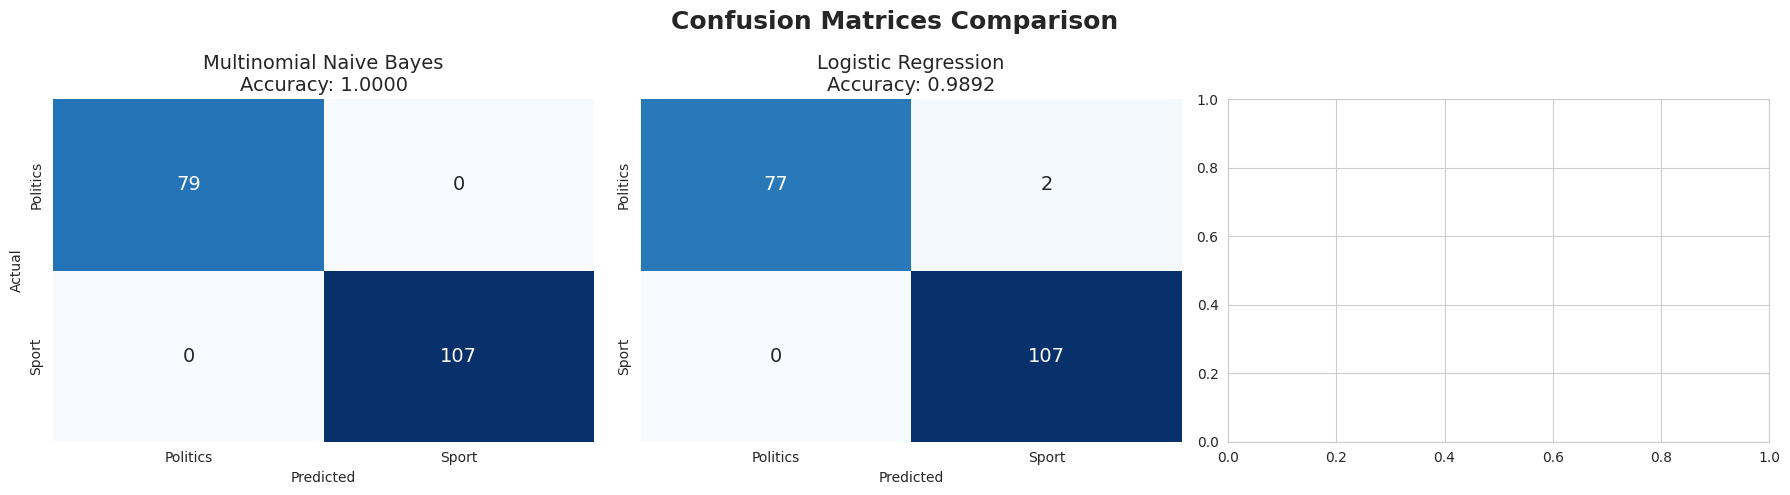

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Set a professional style
sns.set_style("whitegrid")

# ==========================================
# 1. Model Comparison Bar Chart
# ==========================================
plt.figure(figsize=(10, 6))

# Prepare data for plotting
# We melt the dataframe to make it suitable for a grouped bar chart
plot_data = comparison_df.melt(id_vars="Model", value_vars=["Accuracy"], var_name="Metric", value_name="Score")

# Create Bar Plot
ax = sns.barplot(x="Model", y="Score", data=plot_data, palette="viridis")
plt.title("Model Accuracy Comparison", fontsize=16, fontweight='bold')
plt.ylim(0.95, 1.01)  # Zoom in to show the small differences
plt.ylabel("Accuracy Score", fontsize=12)
plt.xlabel("Algorithm", fontsize=12)

# Add the numbers on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# ==========================================
# 2. Confusion Matrix Heatmaps (Side-by-Side)
# ==========================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices Comparison', fontsize=18, fontweight='bold')

for i, (name, model) in enumerate(models.items()):
    # Get predictions
    y_pred = model.predict(X_val_tfidf)
    cm = confusion_matrix(y_val, y_pred)

    # Plot Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Politics', 'Sport'], yticklabels=['Politics', 'Sport'],
                cbar=False, annot_kws={"size": 14})

    axes[i].set_title(f"{name}\nAccuracy: {comparison_df[comparison_df['Model']==name]['Accuracy'].values[0]:.4f}", fontsize=14)
    axes[i].set_xlabel('Predicted')
    if i == 0: axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ==========================================
# 3. Top 15 Keywords (Feature Importance)
# ==========================================
# We use the SVM coefficients for this visualization as they are easiest to interpret
# (Positive = Sport, Negative = Politics)

def plot_top_features(vectorizer, model, n=15):
    feature_names = vectorizer.get_feature_names_out()

    # Check if model is SVM or Logistic Regression (Linear models)
    if hasattr(model, 'coef_'):
        coefs = model.coef_.flatten()

        # Sort coefficients
        top_indices = coefs.argsort()[-n:][::-1] # Top positive (Sport)
        bottom_indices = coefs.argsort()[:n]     # Top negative (Politics)

        top_features = [(feature_names[i], coefs[i]) for i in top_indices]
        bottom_features = [(feature_names[i], coefs[i]) for i in bottom_indices]

        # Create Plot
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'Top {n} Discriminating Words (SVM Model)', fontsize=16, fontweight='bold')

        # Sport Plot
        names, scores = zip(*top_features)
        sns.barplot(x=list(scores), y=list(names), ax=axes[1], palette="Greens_r")
        axes[1].set_title("Top Words for SPORT (Positive Coef)", fontsize=14)
        axes[1].set_xlabel("Coefficient Strength")

        # Politics Plot
        names, scores = zip(*bottom_features)
        # Invert scores for visualization so bars go right
        sns.barplot(x=[abs(s) for s in scores], y=list(names), ax=axes[0], palette="Reds_r")
        axes[0].set_title("Top Words for POLITICS (Negative Coef)", fontsize=14)
        axes[0].set_xlabel("Coefficient Strength")

        plt.tight_layout()
        plt.show()

# Run the function using your SVM model (make sure 'svm_model' is the variable name of your SVM)
# If your SVM is inside the 'models' dictionary, access it like this:
# Note: You need to have 'svm_model' available. If you didn't save it,
# re-run the SVM training line: svm_model = SVC(kernel='linear').fit(X_train_tfidf, y_train)

# Assuming you have the SVM model saved from earlier:
# plot_top_features(tfidf, svm_model)

In [13]:
plot_top_features(tfidf, models['Support Vector Machine (SVM)'])

KeyError: 'Support Vector Machine (SVM)'

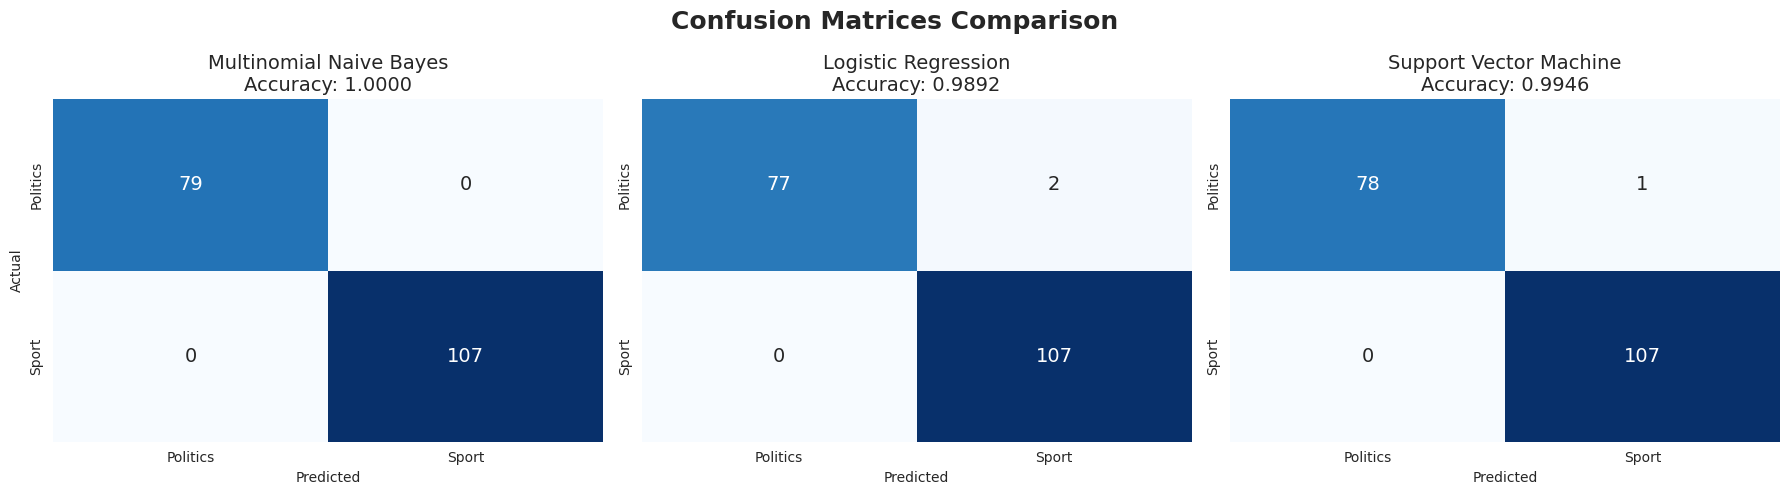

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 1. Update the dictionary to include ALL three models
# (We re-define it here to be safe)
models = {
    "Multinomial Naive Bayes": models['Multinomial Naive Bayes'],
    "Logistic Regression": models['Logistic Regression'],
    "Support Vector Machine": svm  # Uses your trained SVM from earlier
}

# If 'svm_model' is not defined (variable lost), uncomment the line below to re-train it quickly:
# models["Support Vector Machine"] = SVC(kernel='linear', C=1).fit(X_train_tfidf, y_train)


# ==========================================
# 2. Confusion Matrix Heatmaps (Side-by-Side)
# ==========================================
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices Comparison', fontsize=18, fontweight='bold')

for i, (name, model) in enumerate(models.items()):
    # Get predictions
    y_pred = model.predict(X_val_tfidf)
    cm = confusion_matrix(y_val, y_pred)

    # Calculate accuracy for title
    acc = accuracy_score(y_val, y_pred)

    # Plot Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Politics', 'Sport'], yticklabels=['Politics', 'Sport'],
                cbar=False, annot_kws={"size": 14})

    axes[i].set_title(f"{name}\nAccuracy: {acc:.4f}", fontsize=14)
    axes[i].set_xlabel('Predicted')
    if i == 0: axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()